#  Climate Change Discourse on Twitter

Isabel Arvelo

# Introduction

**Motivation:**

* What are the main topics, themes, and narratives that dominate climate change discussions on Twitter? What does the discourse tend to focus on?

* What individuals, organizations, locations, and other entities are most influential in shaping the climate change narrative on Twitter?

Analyzing tweets about climate change can reveal dominant themes and narratives through keyword analysis and topic modeling, showcasing what aspects of climate change are most discussed. Named Entity Recognition (NER) helps identify influential figures, organizations, and locations that frequently appear in the discourse. By examining retweets, mentions, and popular hashtags, we can pinpoint key voices and movements that resonate with the Twitter audience, offering a snapshot of the most impactful elements shaping the climate change narrative on the platform.


**Dataset:** [Kaggle: Climate Change Tweets](https://www.kaggle.com/datasets/die9origephit/climate-change-tweets)

The dataset includes the top daily tweets containing the keyword 'Climate Change'. It contains 11 columns and it covers the period from 01/01/2022 to 19/07/2022. The tool used to scrape the data from Twitter can be found [here](https://github.com/Altimis/Scweet).

In [76]:
# Importing libraries

# Standard libraries
import re
import csv
import string
import itertools
import collections
from collections import Counter
import unicodedata

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Natural language processing libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import spacy
from spellchecker import SpellChecker

# Machine learning and text analysis
import gensim
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Miscellaneous
from PIL import Image
from imojify import imojify


*Warnings*: 

There are several "FutureWarning" notifications in the notebook because parts of the code are using functions or settings that are considered "old ways" of doing things. These methods still work for now, which is why the  output is still correct. However, these warnings are a heads-up that in future versions of the libraries, these methods might no longer be supported. So, while everything runs fine currently, there might be issues if the libraries are updated and the code isn't adjusted accordingly.

## Data Cleaning and Pre Processing

There may be code or analysis present in the notebook that is not in the presentation, but the notebook represents the complete exploratory data analysis exercise and the presentation is a concise synthesis of the three analyses I found to be the most interesting or relevant. **The plots included in the presentataion are clearly labeled with "In Presentation" to enable document searching for those specific code blocks.**

In [128]:
# Reading the data
df = pd.read_csv('Climate change_2022-1-17_2022-7-19.csv')

In [129]:
df.columns

Index(['UserScreenName', 'UserName', 'Timestamp', 'Text', 'Embedded_text',
       'Emojis', 'Comments', 'Likes', 'Retweets', 'Image link', 'Tweet URL'],
      dtype='object')

In [130]:
print(f"There are {df.shape[0]} tweets in the dataset from {df['UserName'].nunique()} unique users.")

There are 9050 tweets in the dataset from 7036 unique users.


In [131]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9050 entries, 0 to 9049
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   UserScreenName  9037 non-null   object
 1   UserName        9050 non-null   object
 2   Timestamp       9050 non-null   object
 3   Text            9050 non-null   object
 4   Embedded_text   9050 non-null   object
 5   Emojis          2026 non-null   object
 6   Comments        6278 non-null   object
 7   Likes           8431 non-null   object
 8   Retweets        8877 non-null   object
 9   Image link      9050 non-null   object
 10  Tweet URL       9050 non-null   object
dtypes: object(11)
memory usage: 777.9+ KB


In [132]:
# Checking for missing values
df.isnull().sum()

UserScreenName      13
UserName             0
Timestamp            0
Text                 0
Embedded_text        0
Emojis            7024
Comments          2772
Likes              619
Retweets           173
Image link           0
Tweet URL            0
dtype: int64

13 tweets do no have User Screen Names, but there are no missing values for UserName so we can use that column as an identifier. There are 7024 missing values for the emoji column, so we can presume tweets in rows with this column missing did not include emoji characters. 

**Make user engagement columns numeric:**

In [133]:
for col in ['Comments', 'Likes', 'Retweets']:
    df[col] = df[col].str.replace('K', '000').str.replace('.', '').str.replace(',', '').astype('Int64')

In [134]:
df["Comments"].describe()

count        6278.0
mean        26.6072
std      193.302912
min             1.0
25%             1.0
50%             3.0
75%             8.0
max          6746.0
Name: Comments, dtype: Float64

In [135]:
df["Likes"].describe()

count         8431.0
mean      238.864785
std      5364.625378
min              1.0
25%              3.0
50%              7.0
75%             19.0
max         213000.0
Name: Likes, dtype: Float64

In [136]:
df["Retweets"].describe()

count         8877.0
mean     1373.824716
std      25792.96492
min              1.0
25%             12.0
50%             24.0
75%             64.0
max        1505000.0
Name: Retweets, dtype: Float64

The minimum values for the Comments, Likes, and Retweets columns is 1, so it is reasonable to assume that missing values for these columns represent instances where the true values is 0. 

In [137]:
# replace null values in Comments, Likes, and Retweets with 0
df["Comments"].fillna(0, inplace=True)
df["Likes"].fillna(0, inplace=True)
df["Retweets"].fillna(0, inplace=True)

**Converting the Timestamp column to datetime format**

In [138]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

**Making all text lower case**

In [139]:
df['Embedded_text'] = df['Embedded_text'].str.lower()

In [140]:
df["Embedded_text"][0]

'the only solution i’ve ever heard the left propose for climate change is more taxes, more control and less freedom.\n\nthey have one playbook and it fails every single time.\n1,683\n2,259\n11.7k'

**Removing engagement metrics for tweet text column**

In [141]:
def remove_metrics(text):
    # Remove the engagement metrics pattern
    cleaned_text = re.sub(r'(\n[\d,.KkMm]+)+$', '', text)
    return cleaned_text

# Apply the function to the Embedded_text column
df['Embedded_text'] = df['Embedded_text'].apply(remove_metrics)

## Exploratory Data Analysis 

In [142]:
df.head()

,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,Lauren Boebert,@laurenboebert,2022-01-17 23:32:38+00:00,Lauren Boebert\n@laurenboebert\n·\nJan 18,the only solution i’ve ever heard the left pro...,NaN,1683,2259,117000,[],https://twitter.com/laurenboebert/status/14832...
1,Catherine,@catherine___c,2022-01-17 22:54:02+00:00,Catherine\n@catherine___c\n·\nJan 17,climate change doesn’t cause volcanic eruptions.,NaN,158,64,762,[],https://twitter.com/catherine___c/status/14832...
2,king Keith,@KaConfessor,2022-01-17 23:51:41+00:00,king Keith\n@KaConfessor\n·\nJan 18,vaccinated tennis ball boy collapses in the te...,NaN,24,118,159,['https://pbs.twimg.com/ext_tw_video_thumb/148...,https://twitter.com/KaConfessor/status/1483225...
3,PETRIFIED CLIMATE PARENT,@climate_parent,2022-01-17 21:42:04+00:00,PETRIFIED CLIMATE PARENT\n@climate_parent\n·\n...,north america has experienced an average winte...,NaN,15,50,158,[],https://twitter.com/climate_parent/status/1483...
4,Thomas Speight,@Thomas_Sp8,2022-01-17 21:10:40+00:00,Thomas Speight\n@Thomas_Sp8\n·\nJan 17,they're gonna do the same with climate change ...,🅾,4,24,127,['https://pbs.twimg.com/profile_images/1544171...,https://twitter.com/Thomas_Sp8/status/14831850...


This is a dataset about climate change tweets in 2022. Each row represents a single tweet with the key word 'climate change'. The columns represent information about the individual who shared the tweet and user engagement. 

**Unique Users**

In [143]:
df['UserName'].value_counts()

UserName
@insideclimate      36
@climatecouncil     31
@ClimateBen         27
@great_thunberg     22
@ECOWARRIORSS       21
                    ..
@gavan_mcfadzean     1
@PoliBard            1
@SecVilsack          1
@OhBeing             1
@robothusiast        1
Name: count, Length: 7036, dtype: int64

The top accounts with tweets about climate change are entities and individuals dedicated to climate awareness and activism, ranging from official councils to passionate advocates. 

**Duplicated Tweets**

In [144]:
percent_duplicates = round((1-(df['Embedded_text'].nunique()/len(df['Embedded_text'])))*100,2)
print(f'{percent_duplicates}% of tweets in the data are duplicated. These likely come from retweets.')

0.43% of tweets in the data are duplicated. These likely come from retweets.


In [145]:
# Find duplicated tweets
duplicated_tweets = df[df.duplicated(subset=['Embedded_text'], keep=False)]
duplicated_tweets

,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
382,Paul Dawson,@PaulEDawson,2022-01-25 22:56:37+00:00,Paul Dawson\n@PaulEDawson\n·\nJan 25,if you found this thread valuable:\n\n1. toss ...,🚢 📚,2,9,53,['https://pbs.twimg.com/card_img/1547773631194...,https://twitter.com/PaulEDawson/status/1486110...
567,Kurt Schlichter,@KurtSchlichter,2022-01-30 22:13:24+00:00,Kurt Schlichter\n@KurtSchlichter\n·\nJan 30,climate change is a hoax,NaN,452,1640,102000,[],https://twitter.com/KurtSchlichter/status/1487...
876,NYT Climate,@nytclimate,2022-02-06 22:20:04+00:00,NYT Climate\n@nytclimate\n·\nFeb 6,“eco-anxiety” used to be a fringe idea in ment...,NaN,46,55,43,['https://pbs.twimg.com/card_img/1548627508073...,https://twitter.com/nytclimate/status/14904502...
1089,Tyler Rogoway,@Aviation_Intel,2022-02-11 23:20:33+00:00,Tyler Rogoway\n@Aviation_Intel\n·\nFeb 12,army releases new plan to adapt to climate cha...,NaN,2,2,15,['https://pbs.twimg.com/card_img/1546744123612...,https://twitter.com/Aviation_Intel/status/1492...
1097,The War Zone,@thewarzonewire,2022-02-11 23:21:03+00:00,The War Zone\n@thewarzonewire\n·\nFeb 12,army releases new plan to adapt to climate cha...,NaN,1,2,18,['https://pbs.twimg.com/card_img/1546744123612...,https://twitter.com/thewarzonewire/status/1492...
...,...,...,...,...,...,...,...,...,...,...,...
8458,Colaba Conversation,@ColabaConvo,2022-07-14 19:30:00+00:00,Colaba Conversation\n@ColabaConvo\n·\nJul 14,the #globalsouth can aspire for absolute decou...,NaN,0,0,0,['https://pbs.twimg.com/card_img/1549013613997...,https://twitter.com/ColabaConvo/status/1547664...
8563,Garret Wassermann,@TheGreenGarret,2022-07-15 15:10:00+00:00,Garret Wassermann\n@TheGreenGarret\n·\nJul 15,the \n@greenpartyofpa\n's gubernatorial ticket...,🌻,1,8,14,['https://pbs.twimg.com/card_img/1549561630941...,https://twitter.com/TheGreenGarret/status/1547...
8597,ORF GeoTech,@orfgeotech,2022-07-15 11:30:01+00:00,ORF GeoTech\n@orfgeotech\n·\nJul 15,the #globalsouth can aspire for absolute decou...,NaN,0,0,0,['https://pbs.twimg.com/card_img/1549013613997...,https://twitter.com/orfgeotech/status/15479063...
8740,Bob Hill,@bobhillbrain,2022-07-16 12:55:02+00:00,Bob Hill\n@bobhillbrain\n·\nJul 16,radiative forcing of #climatechange from the c...,NaN,0,0,0,['https://pbs.twimg.com/card_img/1548354698364...,https://twitter.com/bobhillbrain/status/154829...


In [146]:
# find which tweets appear the most often
duplicated_tweets['Embedded_text'].value_counts().max()

4

In [147]:
duplicated_tweets['Embedded_text'].nunique()

34

There are 34 unique tweets that appear between 2 and 4 times in the dataset. 

**Most common hashtags**

Hashtags are keywords or phrases prefixed with the "#" symbol used on social media platforms to categorize content, making it easier for users to find and follow specific topics or trends. Analyzing the most common hashtags in this corpus of tweets about climate change can reveal prevailing themes, concerns, campaigns, and public sentiments, providing insights into the dynamics and focus of the ongoing climate discourse.

In [148]:
# Hashtage Extraction 
def hashtag_extract(tweet):

    hashtags = []
    
    for i in tweet:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()),
                       'count': list(frequency.values())})
    hashtag_df = hashtag_df.nlargest(15, columns="count")

    return hashtag_df

# Extracting the hashtags from tweets in each class
df_hashtags = hashtag_extract(df['Embedded_text'])

df_hashtags.head(10)

,hashtag,count
1,climatechange,351
16,auspol,247
5,climatecrisis,160
13,climate,145
22,climateaction,96
352,insiders,81
4,climateemergency,68
122,climateactionnow,47
420,ausvotes,38
64,cdnpoli,36


/Users/isabelarvelo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/isabelarvelo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/isabelarvelo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


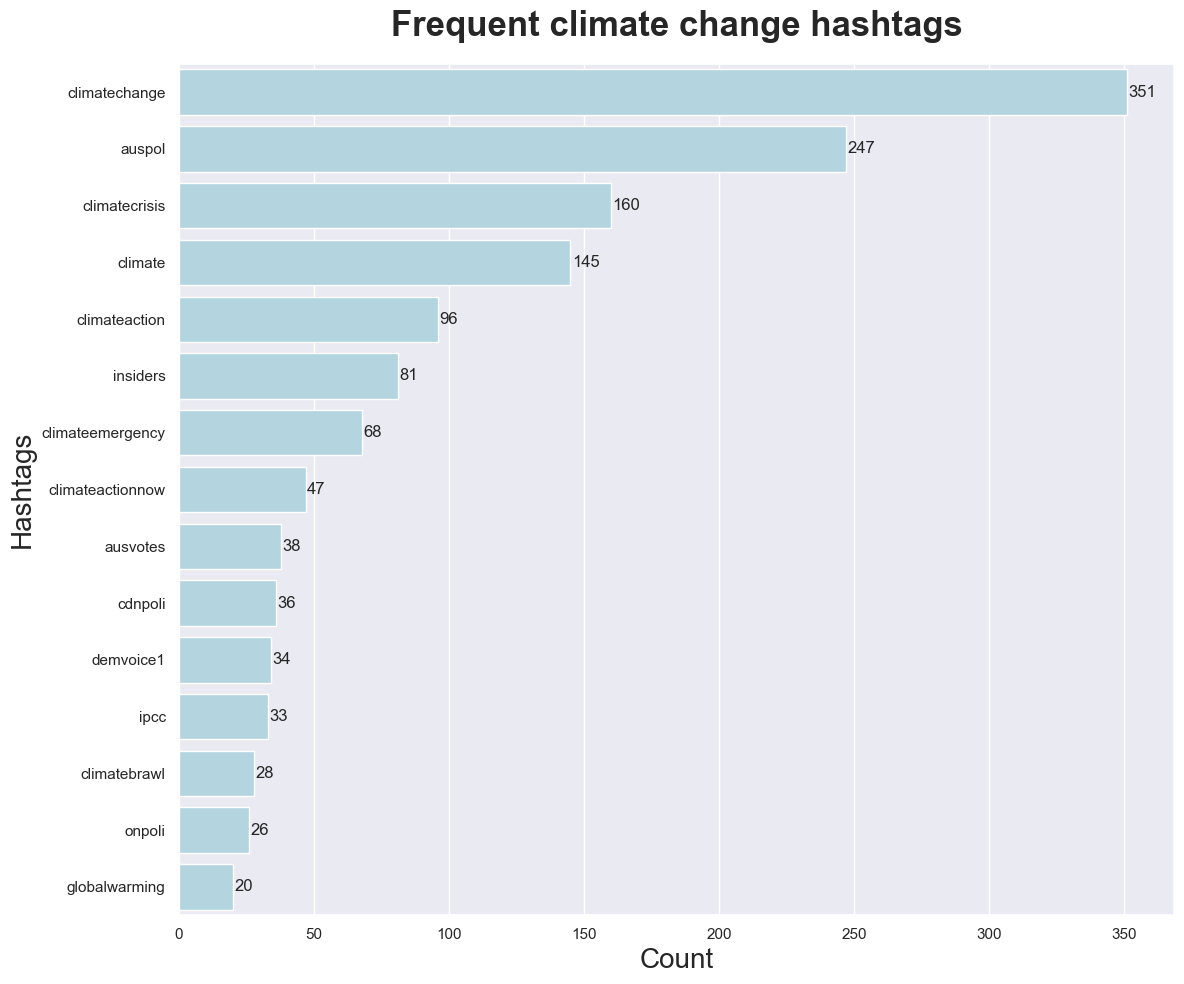

In [149]:
# same color for all bars 
ax = sns.barplot(data=df_hashtags, x='count', y='hashtag', color='lightblue')

#Make the plot bigger
sns.set(rc={'figure.figsize':(12,10)})
#sns.set_style('whitegrid')

# Loop through each bar (rectangle) to add text labels
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.5,       # x position of text, you can adjust 0.5 for spacing
            p.get_y() + p.get_height()/2,  # y position of text, centered vertically
            '{:.0f}'.format(width),        # format of the value to be displayed
            ha="left",                      # alignment
            va="center",                    # alignment
            fontsize=12)                    # font size

# Your other plot customizations
plt.title('Frequent climate change hashtags', fontsize=25, fontweight='bold', pad=20)
plt.xlabel('Count', fontsize=20)
plt.ylabel('Hashtags', fontsize=20)
plt.tight_layout()
plt.show()

There are 15 unique hashtags found among the tweets in the dataset. The hashtages reveal that climate change was a major topic of discussion on Twitter in 2022, especially in the context of Australian politics. There's a clear sense of urgency in the discourse, with hashtags emphasizing the immediate need for action. The intersection of climate change with politics suggests that it was a pivotal issue in public policy and political campaigns during this period.

**Word Count**

In [ ]:
df['word_count'] = df['Embedded_text'].apply(lambda x: len(str(x).split()))
df['word_count'].describe()

In [ ]:
sns.histplot(df['word_count'], bins = 60, kde=True);
# add kde plot


# Add Ttitle and axis names
plt.title('Distribution of word count in tweets', fontsize=25, fontweight='bold', pad=20)
plt.xlabel('Word Count', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(18, 5))
sns.boxplot(data=df, x='word_count',   palette='Set2')

# Add Title and axis names
plt.title('Distribution of word count in tweets', fontsize=25, fontweight='bold', pad=20)
plt.xlabel('Word Count', fontsize=20)


**Likes, Comments, and Retweets**

In [ ]:
df['Comments'].describe()

In [ ]:
df['Likes'].describe()

In [ ]:
df['Retweets'].describe()

In [ ]:
#split retweets into three equally sized bins
df['retweet_bins'] = pd.qcut(df['Retweets'], q=3, labels=['Low', 'Medium', 'High'])

In [ ]:
low_rt_wc = df[df['retweet_bins'] == "Low"]["word_count"].describe().rename("Low")
med_rt_wc = df[df['retweet_bins'] == "Medium"]["word_count"].describe().rename("Medium")
high_rt_wc = df[df['retweet_bins'] == "High"]["word_count"].describe().rename("High")

pd.concat([low_rt_wc, med_rt_wc, high_rt_wc], axis=1)

In [ ]:
# three histograms of word count for tweets in each retweet bin 
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
fig.suptitle('Word count for tweets in each retweet bin', fontsize=20, fontweight='bold', y=1.05)
fig.text(0.5, -0.01, 'Word count', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Count', va='center', rotation='vertical', fontsize=15)

sns.histplot(ax=axes[0], data=df[df['retweet_bins']=='Low'], x='word_count', bins=60, color='lightblue')
axes[0].set_title('Low retweet bin', fontsize=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_xlim([0, 60])
#print median underneath figure
axes[0].text(0.5, -0.2, 'Median: 15', ha='center', fontsize=12, transform=axes[0].transAxes)

sns.histplot(ax=axes[1], data=df[df['retweet_bins']=='Medium'], x='word_count', bins=60, color='lightblue')
axes[1].set_title('Medium retweet bin', fontsize=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim([0, 60])
axes[1].text(0.5, -0.2, 'Median: 16', ha='center', fontsize=12, transform=axes[1].transAxes)

sns.histplot(ax=axes[2], data=df[df['retweet_bins']=='High'], x='word_count', bins=60, color='lightblue')
axes[2].set_title('High retweet bin', fontsize=15)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_xlim([0, 60])
axes[2].text(0.5, -0.2, 'Median: 17', ha='center', fontsize=12, transform=axes[2].transAxes)


In [ ]:
# correlation between retweets and word count
#print correlation 
corr = df['word_count'].corr(df['Retweets'])
corr


There doesn't appear to be a meaningful relationship between word count and retweets. 

**Pre-processing text data from tweets for further analysis**

In [150]:
# Create a set of stopwords
stop_words = stopwords.words('english')
# Add punctuation to stopwords
stopwords_and_punct = set(stop_words + list(string.punctuation))

# Add "replying", "tweet" and "u" to stopwords
stopwords_and_punct.update(["replying", "tweet", "u"])

# Function to clean text
def clean_text(text):
    # Tokenize the text by splitting on spaces and stripping each token
    tokens = [word.strip(string.punctuation) for word in text.split()]
    # Remove stopwords and punctuation
    cleaned_tokens = [word for word in tokens if word not in stopwords_and_punct and word != '']
    return ' '.join(cleaned_tokens)

df['Embedded_text'] = df['Embedded_text'].apply(clean_text)
df['Embedded_text']

0       solution i’ve ever heard left propose climate ...
1         climate change doesn’t cause volcanic eruptions
2       vaccinated tennis ball boy collapses tennis co...
3       north america experienced average winter tempe...
4       they're gonna climate change starts get really...
                              ...                        
9045    climatechange greatest story earth end epic wr...
9046    jh336405 acuna_r 41 others stefan rahmstorf......
9047    texans asked use less electricity conserve wat...
9048    sea levels rising communities scrambling adapt...
9049    uts creates algae-analysing robot combat clima...
Name: Embedded_text, Length: 9050, dtype: object

In [100]:
df['Embedded_text'][0]

'solution i’ve ever heard left propose climate change taxes control less freedom one playbook fails every single time'

In [151]:
# Function to remove URLs
def remove_url(tweet):
    tweet = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet)
    return tweet

df['Embedded_text'] = df['Embedded_text'].apply(remove_url)
df['Embedded_text'].head()

0    solution i’ve ever heard left propose climate ...
1      climate change doesn’t cause volcanic eruptions
2    vaccinated tennis ball boy collapses tennis co...
3    north america experienced average winter tempe...
4    they're gonna climate change starts get really...
Name: Embedded_text, dtype: object

In [102]:
df['Embedded_text'][0]

'solution i’ve ever heard left propose climate change taxes control less freedom one playbook fails every single time'

In [152]:
# Function to remove mentions and hashtags
def remove_mentions_hashs(tweet):
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet) #Remove mentions
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet) #Remove hashtags
    return tweet

df['Embedded_text'] = df['Embedded_text'].apply(remove_mentions_hashs)
df['Embedded_text'][0]

'solution i’ve ever heard left propose climate change taxes control less freedom one playbook fails every single time'

In [153]:
# Function to remove emojis
def remove_emojis(tweet):
    pat =      re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return pat.sub(r'', tweet)

df['Embedded_text'] = df['Embedded_text'].apply(remove_emojis)
df['Embedded_text'][0]

'solution i’ve ever heard left propose climate change taxes control less freedom one playbook fails every single time'

In [154]:
def remove_empty_strings1(tweet):
    tweet = re.sub(r"^\s+|\s+$", '', tweet)
    return tweet

# Check if it works/what it looks like
df['Embedded_text'] = df['Embedded_text'].apply(remove_empty_strings1)
df['Embedded_text'][0]

'solution i’ve ever heard left propose climate change taxes control less freedom one playbook fails every single time'

In [155]:

def remove_nonascii(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# Check if it works
df['Embedded_text'] = df['Embedded_text'].apply(remove_nonascii)
df.head()

,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,Lauren Boebert,@laurenboebert,2022-01-17 23:32:38+00:00,Lauren Boebert\n@laurenboebert\n·\nJan 18,solution ive ever heard left propose climate c...,NaN,1683,2259,117000,[],https://twitter.com/laurenboebert/status/14832...
1,Catherine,@catherine___c,2022-01-17 22:54:02+00:00,Catherine\n@catherine___c\n·\nJan 17,climate change doesnt cause volcanic eruptions,NaN,158,64,762,[],https://twitter.com/catherine___c/status/14832...
2,king Keith,@KaConfessor,2022-01-17 23:51:41+00:00,king Keith\n@KaConfessor\n·\nJan 18,vaccinated tennis ball boy collapses tennis co...,NaN,24,118,159,['https://pbs.twimg.com/ext_tw_video_thumb/148...,https://twitter.com/KaConfessor/status/1483225...
3,PETRIFIED CLIMATE PARENT,@climate_parent,2022-01-17 21:42:04+00:00,PETRIFIED CLIMATE PARENT\n@climate_parent\n·\n...,north america experienced average winter tempe...,NaN,15,50,158,[],https://twitter.com/climate_parent/status/1483...
4,Thomas Speight,@Thomas_Sp8,2022-01-17 21:10:40+00:00,Thomas Speight\n@Thomas_Sp8\n·\nJan 17,they're gonna climate change starts get really...,🅾,4,24,127,['https://pbs.twimg.com/profile_images/1544171...,https://twitter.com/Thomas_Sp8/status/14831850...


In [156]:
df["Embedded_text"][0]

'solution ive ever heard left propose climate change taxes control less freedom one playbook fails every single time'

In [157]:
def remove_emojis(tweet):
    pat =      re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return pat.sub(r'', tweet)

# Check if the function works
df['Embedded_text'] = df['Embedded_text'].apply(remove_emojis)
df["Embedded_text"][0]

'solution ive ever heard left propose climate change taxes control less freedom one playbook fails every single time'

In [158]:
def remove_empty_strings1(tweet):
    tweet = re.sub(r"^\s+|\s+$", '', tweet)
    return tweet

# Check if the function works
df['Embedded_text'] = df['Embedded_text'].apply(remove_empty_strings1)
df["Embedded_text"][0]

'solution ive ever heard left propose climate change taxes control less freedom one playbook fails every single time'

In [159]:
def remove_numbers(tweet):
    tweet = re.sub(r"\d+", "", tweet)
    return tweet
df['Embedded_text'] = df['Embedded_text'].apply(remove_numbers)

In [160]:
df = df[df['Embedded_text'] != 'NaN']
df = df.reset_index(drop = True)

In [161]:
# Initialize spell checker
# spell = SpellChecker()

# def correct_spelling(text):
#     words = text.split()
#     misspelled = spell.unknown(words)
#     for word in misspelled:
#         corrected_word = spell.correction(word)
        
#         # Check if corrected_word is None
#         if corrected_word is None:
#             continue
        
#         text = text.replace(word, corrected_word)
#     return text


# df['Embedded_text'] = df['Embedded_text'].apply(correct_spelling)

In [125]:
# SENTIMENT ANALYSIS
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df['polarity'] = df['Embedded_text'].apply(pol)
df['subjectivity'] = df['Embedded_text'].apply(sub)
df.loc[:, ['Embedded_text', 'polarity', 'subjectivity']].head(10)

,Embedded_text,polarity,subjectivity
0,solution ive ever heard left propose climate c...,-0.184524,0.145238
1,climate change doesnt cause volcanic eruptions,0.000000,0.000000
2,vaccinated tennis ball boy collapses tennis co...,-0.125000,0.375000
3,north america experienced average winter tempe...,0.216667,0.433333
4,they're gonna climate change starts get really...,-0.121212,0.455556
5,hello america would ever thought world could t...,-0.450000,0.750000
6,fucking hell weather makes really fucking anxi...,-0.370000,0.680000
7,great finally important unesco/scor publicatio...,0.600000,0.737500
8,climate change one world's pressing problems r...,0.100000,0.700000
9,people start questioning johnson got big calls...,-0.335714,0.572619


In [ ]:
df['polarity'].describe()

* The average polarity of your text data is approximately 0.062, which suggests that, on average, the texts lean slightly towards being positive.
* The minimum polarity is -1, which means some texts are extremely negative.
* The maximum polarity is 1, indicating that some texts are extremely positive.
* The median (50%) polarity is 0.033, which is close to neutral but slightly positive

In [ ]:
df['subjectivity'].describe()

* The average subjectivity of your text data is approximately 0.403, which suggests that, on average, the texts are somewhat subjective.
* The minimum subjectivity is 0, which means some texts are entirely objective.
* The maximum subjectivity is 1, indicating that some texts are entirely subjective.
* The median (50%) subjectivity is approximately 0.409, which means the central tendency of your data leans towards being slightly subjective.

## Named Entity Recognition: In Presentation 

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [169]:
# Load the spacy model

def entity_extractor(tweets):
    
    def get_entities(tweet, label):  
        # Consolidate specific mentions of "Joe Biden"
        tweet = tweet.replace("joe biden", "joebiden")
        
        words = nlp(tweet)
        entities = [w.text for w in words.ents if w.label_ == label and w.text.lower() != "gif alt"]
        
        # Convert back JoeBiden to Joe Biden for display purposes
        entities = ["joe biden" if e == "joebiden" else e for e in entities]
        
        return entities

    
    def top_entities(series, label):
        entities = series.apply(lambda x: get_entities(x, label))
        entities = [x for sub in entities for x in sub]
        entity_counter = Counter(entities)
        
        top_10_entities = [entity[0] for entity in entity_counter.most_common(12)] # Get a couple of extra in case we remove some
        
        # Prioritize Joe Biden over Joe or Biden
        if "Joe Biden" in top_10_entities:
            top_10_entities = [e for e in top_10_entities if e not in ["joe", "biden"]]
        
        return top_10_entities[:10]  # Return only top 10


    
    # Extract the top 10 entities for each category
    people = top_entities(tweets, 'PERSON')
    orgs = top_entities(tweets, 'ORG')
    gpes = top_entities(tweets, 'GPE')
    
    # Create a dataframe to store the information
    df = pd.DataFrame({
        'people': people,
        'organizations': orgs,
        'geopolitics': gpes
    })
    
    df.index = range(1, len(df) + 1)
    
    return df

# Test (assuming you have a dataframe df with an "Embedded_text" column)
result_df = entity_extractor(df["Embedded_text"])
result_df

,people,organizations,geopolitics
1,putin,un,australia
2,anthony albanese,supreme court,california
3,scott morrison,congress,china
4,joe,senate,russia
5,biden,gop,canada
6,taylor,epa,india
7,joe manchin,abc.net.au,america
8,morrison,abc,pakistan
9,john kerry,nasa,texas
10,boris johnson,cnn,florida


**Tokenization**

In [170]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()

def tokenize(text):
    return tokenizer.tokenize(text)

df['Embedded_text'] = df['Embedded_text'].apply(tokenize)
df['Embedded_text'].head()

0    [solution, ive, ever, heard, left, propose, cl...
1    [climate, change, doesnt, cause, volcanic, eru...
2    [vaccinated, tennis, ball, boy, collapses, ten...
3    [north, america, experienced, average, winter,...
4    [they're, gonna, climate, change, starts, get,...
Name: Embedded_text, dtype: object

In [171]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/isabelarvelo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [172]:
# Part-of-speech tagging
def pos_tag_text(tokens):
    return nltk.pos_tag(tokens)

df['POS_tags'] = df['Embedded_text'].apply(pos_tag_text)

In [173]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(text):
    return [lemmatizer.lemmatize(w) for w in text]

df['Embedded_text'] = df['Embedded_text'].apply(lemmatize)

In [174]:
# Count the frequency of words in the dataset
all_tweets = list(df["Embedded_text"])
all_tokens = list(itertools.chain(*all_tweets))
token_counts = collections.Counter(all_tokens)

In [175]:
token_counts.most_common(22)

[('climate', 13109),
 ('change', 11390),
 ('quote', 1107),
 ('new', 1091),
 ('people', 1071),
 ('u', 894),
 ('year', 891),
 ('world', 811),
 ('action', 785),
 ('one', 781),
 ('need', 774),
 ('say', 744),
 ('global', 711),
 ('time', 694),
 ('like', 667),
 ('impact', 608),
 ('energy', 607),
 ('show', 569),
 ('right', 543),
 ('government', 536),
 ('it', 533),
 ('get', 526)]

In [176]:
df_token_counts = pd.DataFrame(token_counts.most_common(22), columns=['Token','Count'])
df_token_counts.head()

,Token,Count
0,climate,13109
1,change,11390
2,quote,1107
3,new,1091
4,people,1071


## Word Count Bar Plot: In Presentation

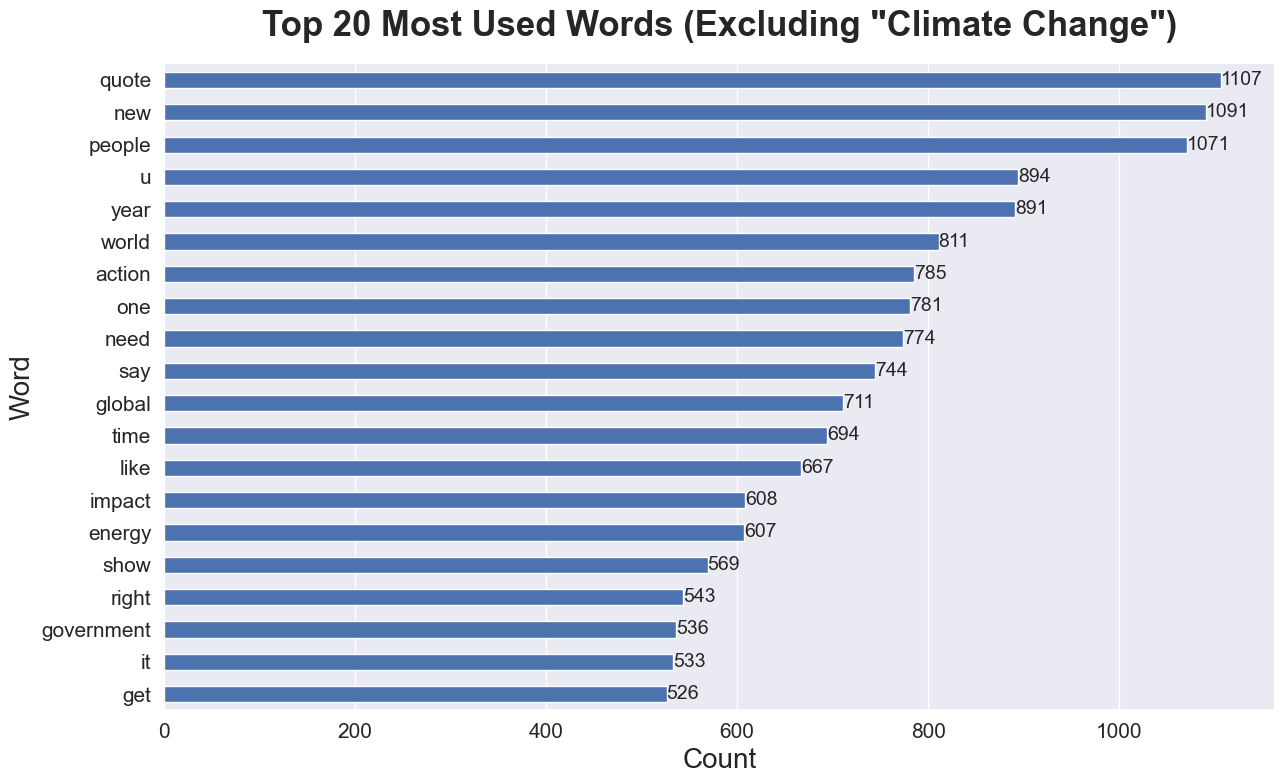

In [177]:
# Exclude rows with Token values 'climate' and 'change'
df_other_token_counts = df_token_counts[~df_token_counts['Token'].isin(['climate', 'change'])]

# Plot the DataFrame
plt.rcParams["figure.figsize"] = (13,8)
ax = df_other_token_counts.sort_values(by = 'Count').plot.barh(x='Token', y='Count', legend=False)
plt.title('Top 20 Most Used Words (Excluding "Climate Change")', fontsize = 25, pad=20, fontweight='bold')
plt.ylabel('Word', fontsize = 20)
plt.yticks(fontsize=15)
plt.xlabel('Count', fontsize = 20)
plt.xticks(fontsize=15)

# Make the plot look nicer
sns.despine()

#get rid of horizontal gridlines
ax.grid(False, axis='y')


# Label each bar with its count value
for p in ax.patches:
    ax.text(p.get_width() + 0.05,     # x position of text (with a small padding)
            p.get_y() + p.get_height()/2,  # y position of text, centered
            int(p.get_width()),      # label text (count value)
            ha="left",               # alignment
            va="center",             # alignment
            fontsize=14, 
            fontweight = "bold")             # font size

plt.tight_layout()
plt.show()


In [178]:
token_counts.most_common(50)

[('climate', 13109),
 ('change', 11390),
 ('quote', 1107),
 ('new', 1091),
 ('people', 1071),
 ('u', 894),
 ('year', 891),
 ('world', 811),
 ('action', 785),
 ('one', 781),
 ('need', 774),
 ('say', 744),
 ('global', 711),
 ('time', 694),
 ('like', 667),
 ('impact', 608),
 ('energy', 607),
 ('show', 569),
 ('right', 543),
 ('government', 536),
 ('it', 533),
 ('get', 526),
 ('make', 524),
 ('crisis', 502),
 ('would', 494),
 ('issue', 494),
 ('fight', 481),
 ('report', 480),
 ('help', 472),
 ('fuel', 466),
 ('policy', 454),
 ('way', 449),
 ('emission', 446),
 ('could', 443),
 ('want', 439),
 ('gas', 438),
 ('take', 437),
 ('water', 434),
 ('today', 424),
 ('health', 422),
 ('carbon', 416),
 ('state', 413),
 ('scientist', 411),
 ('fossil', 403),
 ('country', 403),
 ('australia', 398),
 ('future', 392),
 ('threat', 390),
 ('may', 384),
 ('day', 381)]

/Users/isabelarvelo/anaconda3/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


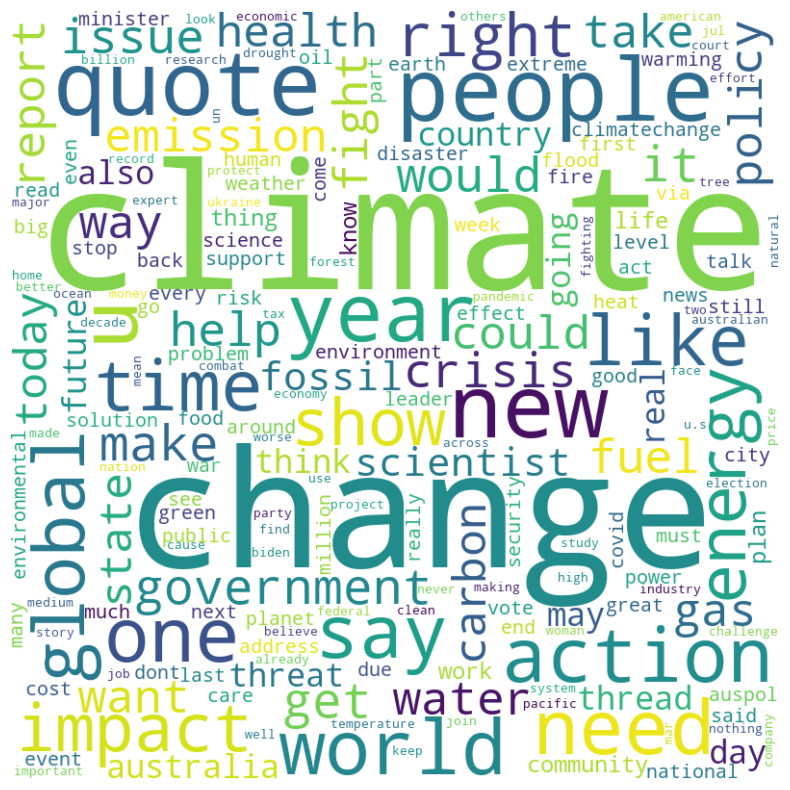

In [179]:
# Convert the list of tuples into a dictionary
word_freq = dict(token_counts)

# Remove the comma (',') from the dictionary, as it's a punctuation and shouldn't be in the word cloud
if ',' in word_freq:
    del word_freq[',']

# Generate the word cloud
wordcloud = WordCloud(background_color="white", width=800, height=800).generate_from_frequencies(word_freq)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Checking for frequency of specific words**

In [180]:
token_counts['fake']

38

In [181]:
token_counts['real']

373

In [182]:
token_counts['hoax']

89

In [183]:
token_counts['trump']

64

In [184]:
token_counts['biden']

183

In [185]:
token_counts['thunberg']

15

**Analyzing Emojis**

In [186]:
emojis = [words for words in df["Emojis"]]

#remove nan
emojis = [x for x in emojis if str(x) != 'nan']
emojis = ''.join(emojis)
split_emojis = re.findall(r'[^ ]', emojis)

emoji_count = Counter(split_emojis)
emoji_count

Counter({'🅾': 2,
         '🌎': 124,
         '🌍': 96,
         '🌏': 78,
         '🦇': 12,
         '🟥': 5,
         '⬜': 1,
         '🟩': 2,
         '➡': 65,
         '✊': 11,
         '🤓': 4,
         '😎': 4,
         '🤔': 47,
         '🐷': 1,
         '🌽': 4,
         '🤘': 3,
         '🐐': 5,
         '🌳': 56,
         '💡': 8,
         '🧵': 53,
         '🌻': 106,
         '💧': 92,
         '⛳': 4,
         '💷': 1,
         '🎧': 7,
         '👇': 112,
         '📖': 3,
         '🔍': 1,
         '⏰': 5,
         '🎖': 2,
         '🤪': 6,
         '🌟': 4,
         '🎼': 4,
         '❤': 52,
         '🏡': 11,
         '💎': 13,
         '🤩': 3,
         '😭': 12,
         '😃': 1,
         '🤑': 5,
         '😐': 4,
         '😩': 3,
         '💀': 6,
         '😔': 6,
         '🦍': 1,
         '⚡': 24,
         '😁': 5,
         '⤵': 6,
         '😳': 12,
         '🖕': 6,
         '🐧': 5,
         '🐬': 10,
         '🐠': 3,
         '🦎': 4,
         '🐯': 3,
         '🦋': 16,
         '🙄': 36,
       

In [187]:
# Find top 10 emojis
top_20_emojis = emoji_count.most_common(20)

In [188]:
top_20_emojis

[('💉', 140),
 ('🌎', 124),
 ('👇', 112),
 ('🌻', 106),
 ('🌊', 98),
 ('🌍', 96),
 ('💧', 92),
 ('🌱', 79),
 ('🌏', 78),
 ('🔥', 74),
 ('💙', 74),
 ('➡', 65),
 ('🌳', 56),
 ('🤣', 54),
 ('🧵', 53),
 ('😷', 53),
 ('❤', 52),
 ('😂', 49),
 ('🤔', 47),
 ('💚', 44)]

In [189]:
df_emoji_counts = pd.DataFrame(emoji_count.most_common(20), columns=['Emoji','Count'])

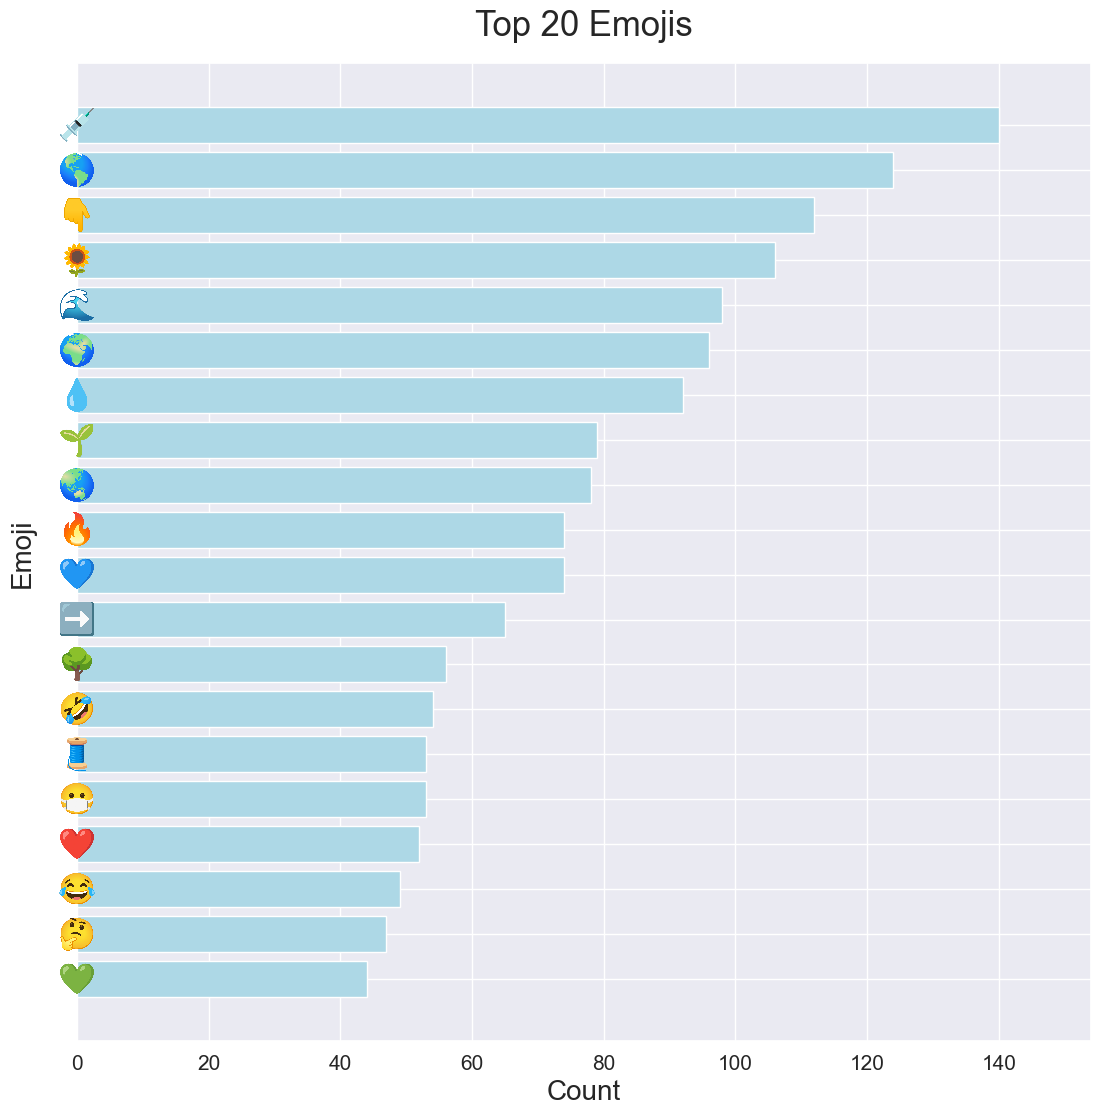

In [190]:
# Adjusting the offset function for horizontal placement of emojis
def offset_image_horizontal(cords, emoji, ax, zoom_level=0.05):
    img_path = imojify.get_img_path(emoji)  # Getting the image path using imojify
    img = plt.imread(img_path)
    im = OffsetImage(img, zoom=zoom_level)
    im.image.axes = ax
    ab = AnnotationBbox(im, (cords[0], cords[1]), frameon=False, boxcoords="data", pad=0)
    ax.add_artist(ab)

# Sorting data for better visualization
df_sorted = df_emoji_counts.sort_values(by='Count', ascending=True)
sorted_emojis = df_sorted['Emoji'].tolist()
sorted_values = df_sorted['Count'].tolist()

# Plotting a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 12))
#Title
plt.title('Top 20 Emojis', fontsize = 25, pad=20)
ax.barh(range(len(sorted_emojis)), sorted_values, align="center", color = "lightblue")
# Y axis label
plt.ylabel('Emoji', fontsize = 20, labelpad=20)
# X axis label
plt.xlabel('Count', fontsize = 20)


# Setting empty y-tick labels as we'll use emojis as labels
ax.set_yticks(range(len(sorted_emojis)))
ax.set_yticklabels(['' for _ in sorted_emojis])

# Increase font size of x ticks
ax.tick_params(axis='x', labelsize=15)

# Add each emoji image to the left of its corresponding bar
for i, e in enumerate(sorted_emojis):
    offset_image_horizontal([0, i], e, ax)

# Adjust x-axis limit
ax.set_xlim((0, max(sorted_values) + max(sorted_values)*0.1))

plt.tight_layout()
plt.show()  # Commented for compatibility with this environment, but you should include it to view the plot.


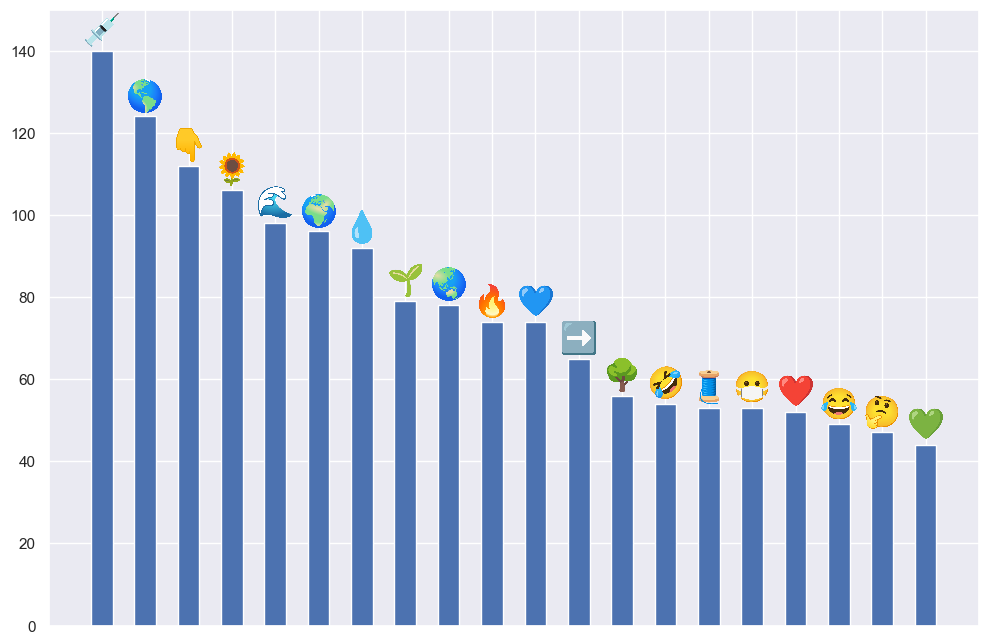

In [191]:
# Given function to add an emoji image to the plot
def offset_image(cords, emoji, ax, zoom_level=0.05):
    img_path = imojify.get_img_path(emoji)
    img = plt.imread(img_path)
    im = OffsetImage(img, zoom=zoom_level)
    im.image.axes = ax
    ab = AnnotationBbox(im, (cords[0], cords[1]), frameon=False, pad=0)
    ax.add_artist(ab)

# Your emoji and value data
emojis = df_emoji_counts['Emoji'].tolist()
values = df_emoji_counts['Count'].tolist()

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(range(len(emojis)), values, width=0.5, align="center")
ax.set_xticks(range(len(emojis)))
ax.set_xticklabels([])
ax.tick_params(axis='x', which='major', pad=26)
ax.set_ylim((0, max(values) + 10))  # Adjust y-axis limit

# Add each emoji image above its corresponding bar
for i, e in enumerate(emojis):
    offset_image([i, values[i] + 5], e, ax)

plt.show()


**Topic Modeling (Latent Dirichlet Allocation)**

LDA is a technique that automatically identifies topics present in a large collection of text. It works by recognizing patterns in which words appear together frequently across documents. By applying LDA, we can categorize our text data into distinct topics, helping us better understand the main themes covered.

In [192]:
import gensim
from gensim import corpora

LDA Topic Modeling

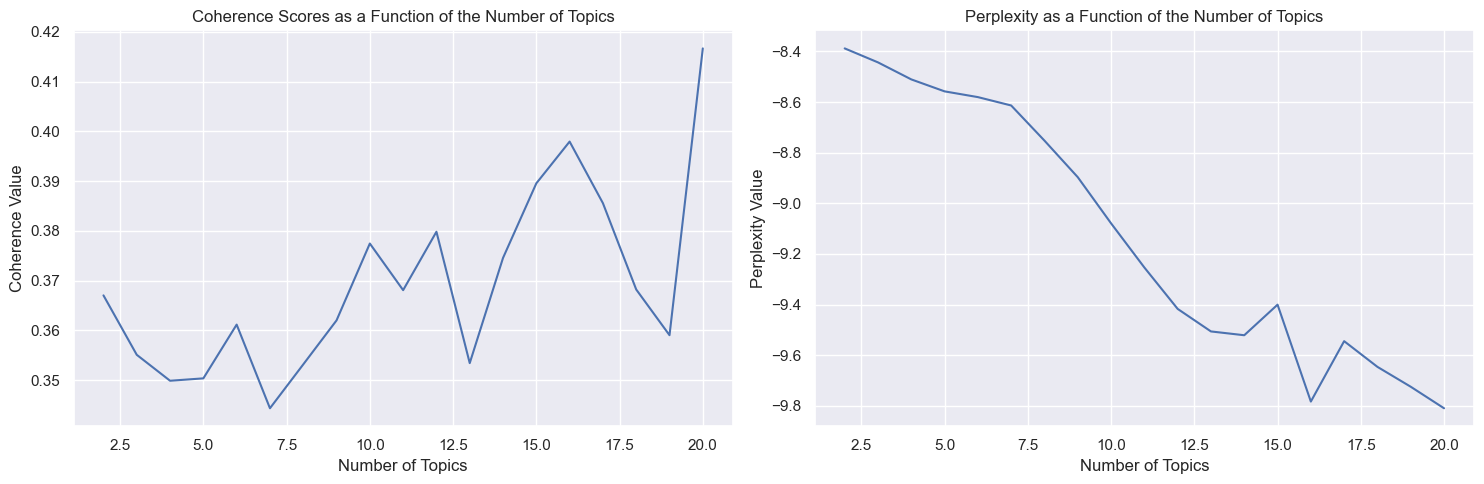

In [193]:
all_tweets = list(df["Embedded_text"])
dictionary = corpora.Dictionary(all_tweets)

# Convert list of tweets (tweets_tokenized) into a Document Term Matrix using the dictionary prepared above
corpus = [dictionary.doc2bow(tweet) for tweet in all_tweets]


# Define the range of topics to test
topic_range = list(range(2, 21))  # for example, testing from 2 to 20 topics

coherence_values = []
perplexity_values = []

for num_topics in topic_range:
    # Train the LDA model
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             random_state=42,
                             chunksize=100,
                             passes=10,
                             per_word_topics=True)
    
    # Compute Coherence Score
    coherence_model = CoherenceModel(model=lda_model, texts=all_tweets, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

    # Compute Perplexity
    perplexity_values.append(lda_model.log_perplexity(corpus))

# Plotting the metrics
plt.figure(figsize=(15, 5))

# Coherence plot
plt.subplot(1, 2, 1)
plt.plot(topic_range, coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Value')
plt.title('Coherence Scores as a Function of the Number of Topics')

# Perplexity plot
plt.subplot(1, 2, 2)
plt.plot(topic_range, perplexity_values)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Value')
plt.title('Perplexity as a Function of the Number of Topics')

plt.tight_layout()
plt.show()


Looks like 16 topics is the best, but for purpose of EDA we will start with only 3

In [200]:
# Running LDA model
LDA = gensim.models.ldamodel.LdaModel

all_tweet_no_cc = [[word for word in tweet if word not in ["climate", "change"]] for tweet in all_tweets]

# Filter out the unwanted tokens
dictionary.filter_tokens(bad_ids=[dictionary.token2id["climate"], dictionary.token2id["change"]])

# Re-create the doc-term matrix after filtering
doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_tweets]

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=58,
                chunksize=1000, passes=50)

# Print the topics discovered by the LDA model
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.014*"heat" + 0.009*"climatechange" + 0.008*"wildfire" + 0.008*"quote" + 0.008*"uk" + 0.008*"heatwave" + 0.008*"weather" + 0.007*"day" + 0.006*"jul" + 0.006*"wave"
Topic: 1 
Words: 0.010*"people" + 0.008*"right" + 0.007*"quote" + 0.006*"it" + 0.006*"like" + 0.006*"time" + 0.006*"u" + 0.005*"get" + 0.005*"action" + 0.005*"issue"
Topic: 2 
Words: 0.014*"fuel" + 0.012*"fossil" + 0.009*"energy" + 0.007*"gas" + 0.007*"oil" + 0.006*"policy" + 0.005*"american" + 0.005*"company" + 0.005*"price" + 0.005*"u.s"
Topic: 3 
Words: 0.013*"harry" + 0.009*"prince" + 0.008*"say" + 0.007*"battered" + 0.007*"left" + 0.007*"helpless" + 0.007*"feeling" + 0.006*"day" + 0.006*"world" + 0.005*"general"
Topic: 4 
Words: 0.011*"new" + 0.008*"impact" + 0.007*"global" + 0.006*"emission" + 0.006*"world" + 0.006*"food" + 0.006*"need" + 0.005*"crisis" + 0.005*"year" + 0.005*"climatechange"


In [204]:
# vis = gensimvis.prepare(lda_model, corpus, dictionary)
# pyLDAvis.display(vis)


## Topic Modeling Word Cloud : In Presentation

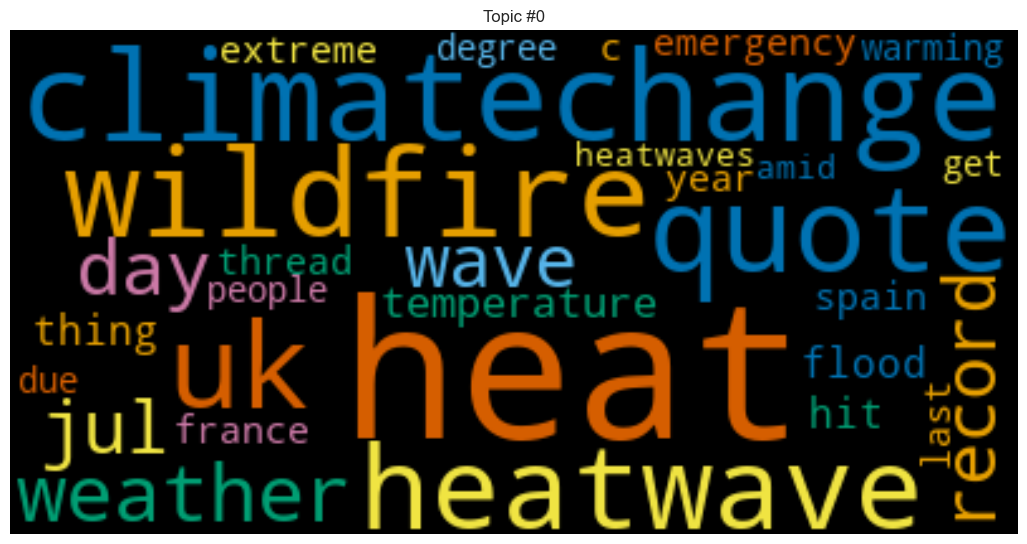

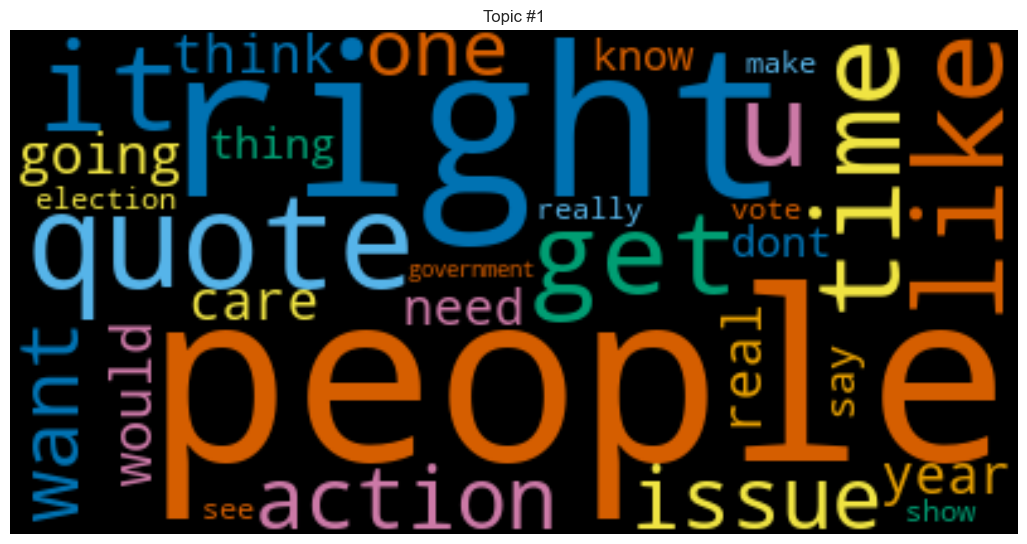

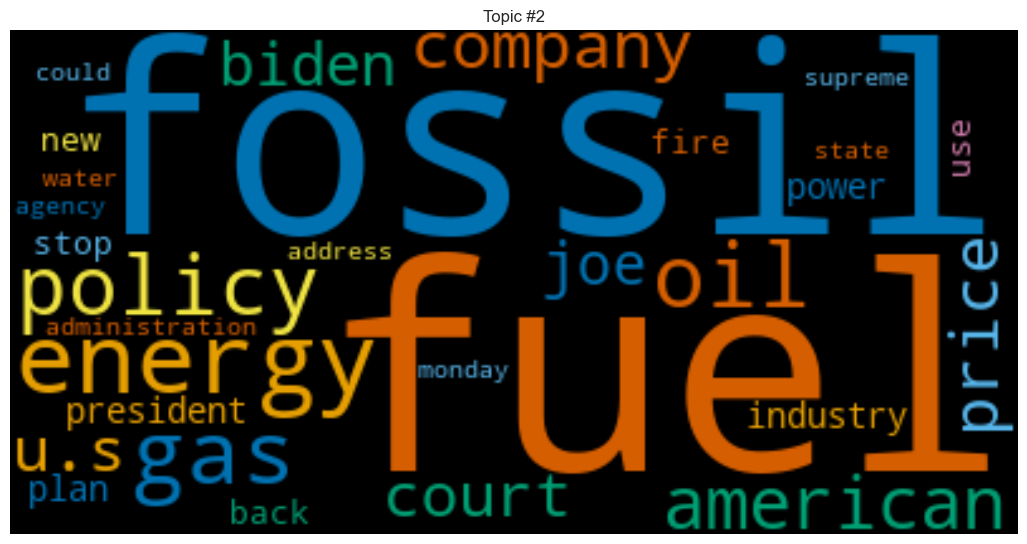

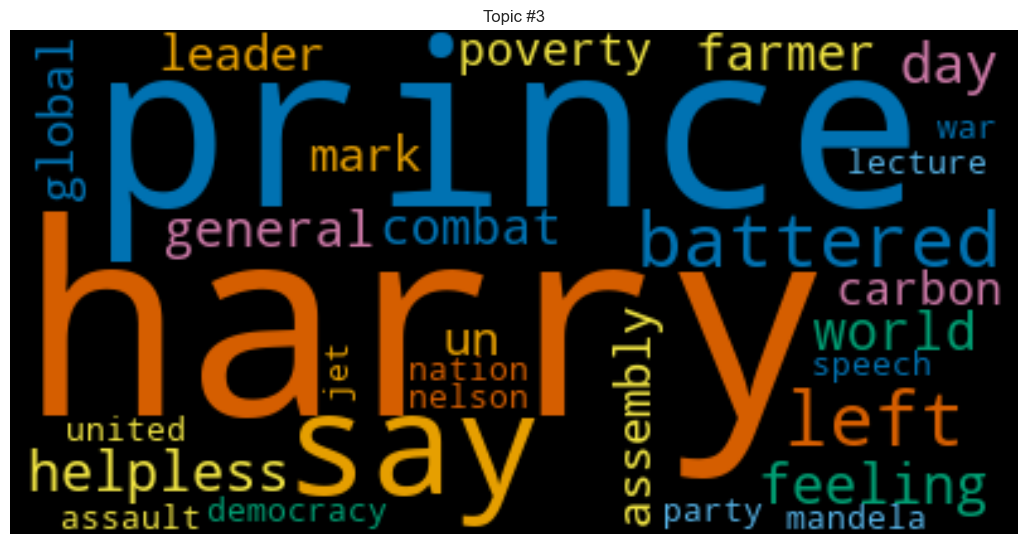

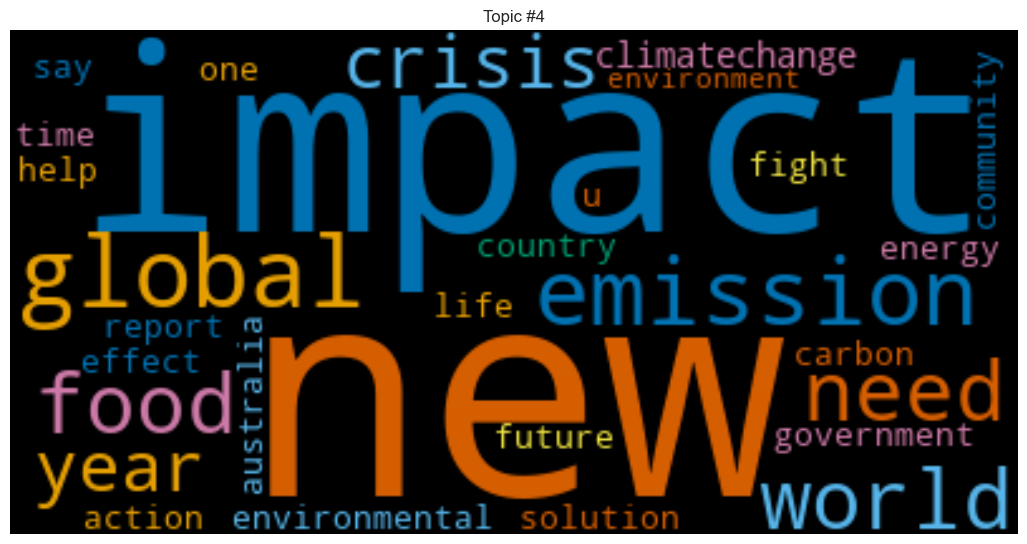

In [202]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Define a colorblind-friendly color palette
colorblind_palette = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # reddish orange
    "#CC79A7"   # pink
]

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return colorblind_palette[random_state.randint(0, len(colorblind_palette)-1)]

for t in range(lda_model.num_topics):
    plt.figure()
    wordcloud = WordCloud(color_func=color_func, random_state=42).fit_words(dict(lda_model.show_topic(t, 30)))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Topic #" + str(t))
    plt.axis("off")
    plt.show()